In [1]:
import osmnx as ox

In [2]:
#loading buildings from Södermalm in Stockholm
tags = {"building": True}
gdf = ox.geometries_from_place("Stockholm", tags)

In [3]:
#choosing only the element_type "way", which perhaps(!) is the correct element_type
gdf = gdf.loc[(gdf.index.get_level_values('element_type') == 'way')]

In [4]:
#according to instructions from osm nx-docs, making correct projection
gdf_proj = ox.project_gdf(gdf)

In [5]:
#using geopandas to calculate areas from the geometric polygons
gdf_proj['area'] = gdf_proj.area

In [6]:
#keeping only buildings with level information
gdf_l = gdf_proj.dropna(subset=['building:levels'])

In [7]:
gdf_l.shape

(9226, 336)

In [ ]:
#this is not an important cell, just testing something
gdf_l['building:levels'].str.contains('[A-Za-z]')

In [ ]:
gdf_l['building:levels'] = gdf_l['building:levels'].astype('float')

In [ ]:
#calculating floor area
gdf_l['floor'] = gdf_l['building:levels'] * gdf_l['area']

In [13]:
gdf_l['floor']

element_type  osmid     
way           4693665       12907.400324
              4880162        6853.864104
              5174887       10031.442144
              5192037        1041.171489
              5192038        2748.634102
                                ...     
              1145158039       32.850202
              1145158040       13.857310
              1145158041       11.480690
              1145158042       23.528134
              1145158043        7.987229
Name: floor, Length: 9226, dtype: float64

In [ ]:
#multiplying floor area with figure from Antti's model, using climate zone 5 for Stockholm
gdf_l['kWh/a'] = gdf_l['floor'] * 159.993

In [15]:
#using this article https://www.sei.org/publications/swedish-heat-energy-system-new-tensions-and-lock-ins-after-a-successful-transition/#:~:text=Fossil%20fuel%20energy%20has%20been,demand%20for%20heating%20in%20buildings.
#to calculate an estimate of the energy mix and it's co2-emissions using Antti's model
co2 = 0.5*0.195 + 0.25*0.104 + 0.08*0.255 + 0.08*0.354 + 0.09*0.403
co2

0.20848999999999998

In [ ]:
#multiplying kWh with co2/kWh for estimate of co2-emissions
gdf_l['co2/a'] = gdf_l['kWh/a'] * co2

In [17]:
import matplotlib.pyplot as plt

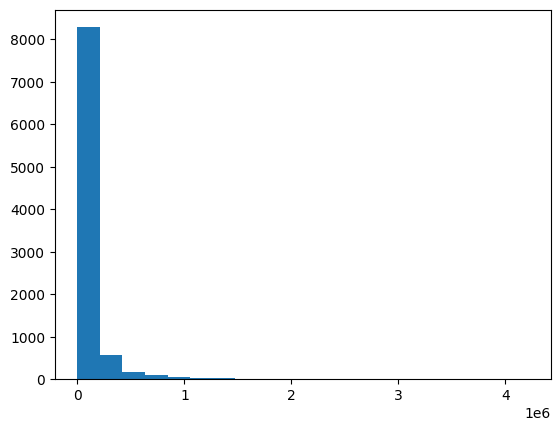

In [23]:
plt.hist(gdf_l['co2/a'], bins=20)
plt.show()